## Lab 6: Image edge detection using derivative operators

Written by: Enrique Mireles Gutiérrez  
ID Number: 513944  
Bachelor: ITR  
Date: 2019-02-10  

### Introduction

On previous lab reports, it was shown that the convolution of a kernel, depending on its values, could be used to blur images. Another application for the convolution of kernels with images is the estimation of the derivative. When a derivative kernel with carefully selected values is convolved with an image, it produces an image that represents the changes in intensity in every direction (x- and y-).

Performing such calculations are useful for finding edges in images. Therefore, these kernels and algorithms are often called edge detection kernels. Important to note is that the x- derivative and the y- derivative must be combined into a single image by adding the squared values of both direction and taking the magnitude. The resulting image is then used for other algorithms such as line finding algorithms. Some well known edge detection kernels are known as Sobel, Prewitt, Scharr and Roberts. This lab reports analyses these kernels and sets the bases for lane detection algorithms.

### Objectives

In this lab, you will learn about image edge detection. Edge detection is an important aspect in computer vision as it allows you to describe an object by one of its feature, which is its shape.

### Procedure

This lab report is subdivided in smaller numbered programs shown below.

#### 1. Importing Libraries

The following libraries are used throughout the lab report:
- cv2: OpenCV library used for artificial vision.
- numpy: Library used for matrix operations.
- matplotlib: Create plots. Requires images in RGB color space.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### 2. Constant definitions

The following lines define the constants used throughout the lab report:

In [2]:
IMAGE_IN_FILENAME = '../fig/vehicular-traffic.jpg'

# Define the Prewitt Filter Kernels in the x and y direction.
PREWITT_KERNEL_X = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], np.float32)
PREWITT_KERNEL_Y = np.rot90(PREWITT_KERNEL_X)

# Define the Scharr Filter Kernels in the x and y direction.
SCHARR_KERNEL_X = np.array([
    [3,  0, -3 ],
    [10, 0, -10],
    [3,  0, -3 ]
], np.float32)
SCHARR_KERNEL_Y = np.rot90(SCHARR_KERNEL_X)

# Define the Roberts Filter Kernels in the x and y direction.
ROBERTS_KERNEL_X = np.array([
    [0,  1],
    [-1, 0],
], np.float32)
ROBERTS_KERNEL_Y = np.rot90(ROBERTS_KERNEL_X)


#### 3. Useful functions

The following functions are used several times. In order to avoid repetition they are defined here.

In [3]:
def is_grayscale(img):
    """
        Returns true if the image is grayscale (channels == 1).
        Returns false if channels > 1.
    """
    
    # If img.shape has a channel value, read it and determine if
    # it is a grayscale image. If it doesn't have, assume that the
    # image is grayscale.
    if (len(img.shape) == 3):
        return img.shape[2] == 1
    return True

def visualize_image(img, fig_number, fig_title):
    """
        Plot image to a matplotlib figure.
    """
    
    # Select the figure.
    plt.figure(fig_number)
    
    # Determine the channels of the image and plot accodingly.
    if (is_grayscale(img)):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    
    # Set plot labels.
    plt.title(fig_title)
    plt.xlabel('x-resolution')
    plt.ylabel('y-resolution')

def read_image_safe(filename, color, conversion=False):
    """
        Read an image in specified color space.
        If the image cannot be opened then exit the program and alert the user.
        Do a color space conversion if specified by the user.
    """
    
    # Read image and if it fails exit.
    img = cv2.imread(filename, color)
    if img is None:
        print('ERROR: image ', filename, 'could not be read')
        exit()
    
    # Do conversion if requested. Return image.
    if conversion:
        return cv2.cvtColor(img, conversion)
    return img

#### 4. Sobel Operator

The following program uses the Sobel operator for edge detection. It first calculates the x and y derivatives to then obtain the magnitude and direction of the first derivative. In the process, a binary image is created for values within a threshold.

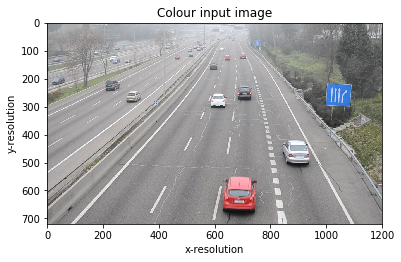

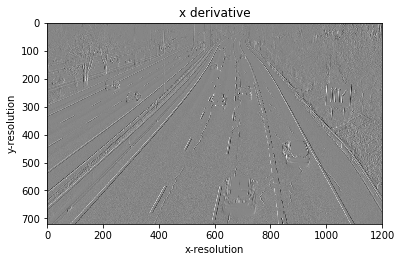

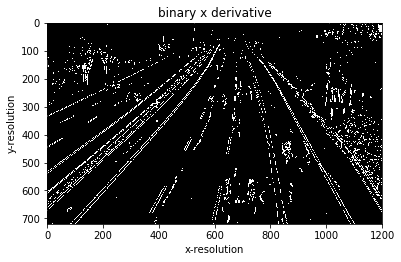

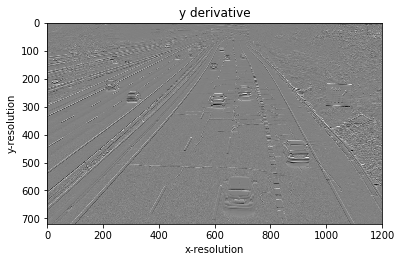

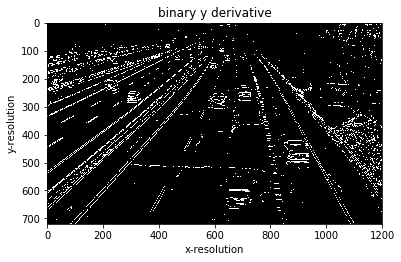

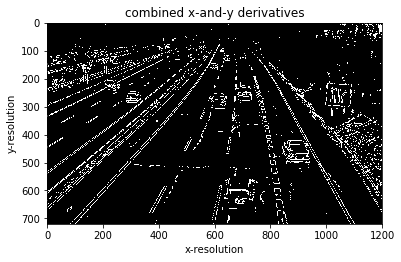

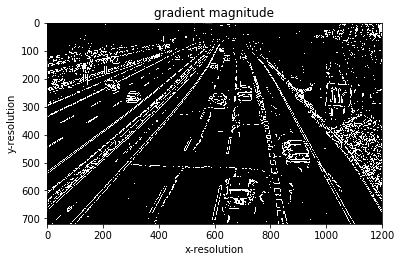

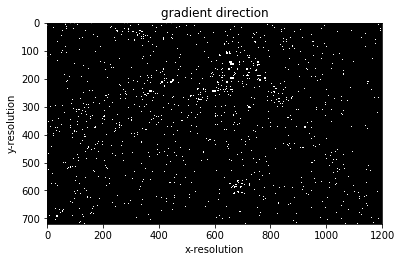

In [4]:
# compute Sobel gradient
def compute_absolute_sobel_gradient(img, ax='x', ksize=3, threshold=(40,140)):

    # 1) check whether img is a colour or greyscale image
    if len(img.shape)>2:

        # convert from colour to greyscale image
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    else:
        # if greyscale grey=img
        grey = img

    # 2) take the derivate in 'ax' axis
    if ax.lower()=='x':

        # apply the Sobel operator along the x axis
        sobel_derivative = cv2.Sobel(grey, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=ksize, scale=1)

    if ax.lower()=='y':

        # apply the Sobel operator along the y axis
        sobel_derivative = cv2.Sobel(grey, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=ksize, scale=1)

    # 3) take the absolute value of the derivative
    sobel_absolute = np.absolute(sobel_derivative)

    # 4) scale to 8-bit (0-255), then convert to type = np.uint8
    sobel_scaled = np.uint8(255 * sobel_absolute / np.max(sobel_absolute))

    # 5) create a mask of 1's where threshold[0] < sobel_scaled < threshold[1]
    binary_output = np.zeros_like(sobel_scaled)
    threshold_min = threshold[0]
    threshold_max = threshold[1]
    binary_output[(sobel_scaled >= threshold_min) & (sobel_scaled <= threshold_max)] = 1

    # return binary_image with gradient being detected along 'ax' axis
    return sobel_derivative, binary_output


# combine x and y derivatives using AND operation
def combine_x_and_y_binary_derivatives(img_derivative_x, img_derivative_y, threshold=(40,120)):

    # verify that both image derivatives are the same size
    if img_derivative_x.shape != img_derivative_y.shape:
        print('ERROR [combine_x_and_y_binary_derivatives]: img_binary_x and img_binary_y images should be of same size')
        exit()

    # 1) take the absolute value of the derivative
    absolute_x = np.absolute(img_derivative_x)
    absolute_y = np.absolute(img_derivative_y)

    # 2) scale to 8-bit (0-255), then convert to type = np.uint8
    absolute_scaled_x = np.uint8(255 * absolute_x / np.max(absolute_x))
    absolute_scaled_y = np.uint8(255 * absolute_y / np.max(absolute_y))

    # 3) create a mask of 1's where threshold[0] < sobel_scaled < threshold[1]
    binary_combined_gradients = np.zeros_like(absolute_scaled_x)
    indx_x = (absolute_scaled_x >= threshold[0]) & (absolute_scaled_x <= threshold[1])
    indx_y = (absolute_scaled_y >= threshold[0]) & (absolute_scaled_y <= threshold[1])
    binary_combined_gradients[indx_x|indx_y] = 1

    # return combined binary x-and-y derivatives
    return binary_combined_gradients


# compute magnitude of x and y derivatives
def compute_magnitude_of_derivatives(img_derivative_x, img_derivative_y, ksize=3, threshold=(40,120)):

    # 1) calculate the magnitude
    gradient_magnitude = np.sqrt(np.power(img_derivative_x, 2) + np.power(img_derivative_y, 2))

    # 2) scale to 8-bit (0 - 255) and convert to type = np.uint8
    gradient_scaled = np.uint8(255 * gradient_magnitude / np.max(gradient_magnitude))

    # 3) create a binary mask where mag thresholds are met
    binary_magnitude = np.zeros_like(gradient_scaled)
    binary_magnitude[(gradient_scaled >= threshold[0]) & (gradient_scaled <= threshold[1])] = 1

    return binary_magnitude


# compute orientation of magnitude of x and y derivatives
def compute_direction(img_derivative_x, img_derivative_y, threshold=(0, np.pi/2)):

    # 1) take the absolute value of the x and y gradients
    gradient_magnitude_x = np.absolute(img_derivative_x)
    gradient_magnitude_y = np.absolute(img_derivative_y)

    # 2) calculate the gradient magnitude direction
    #gradient_direction = np.arctan2(gradient_magnitude_y, gradient_magnitude_x)
    gradient_direction = np.arctan2(img_derivative_y, img_derivative_x)

    # 3) reate a binary mask where direction thresholds are met
    binary_direction = np.zeros_like(gradient_direction)
    binary_direction[(gradient_direction >= threshold[0]) & (gradient_direction <= threshold[1])] = 1

    return binary_direction


# pipeline
def run_pipeline(img_name):

    # read image
    img = read_image_safe(img_name, cv2.IMREAD_COLOR, cv2.COLOR_BGR2RGB)

    # compute sobel derivative along x axis
    img_derivative_x, img_binary_x = compute_absolute_sobel_gradient(img, ax='x', ksize=3, threshold=(40,140))

    # compute sobel derivative along y axis
    img_derivative_y, img_binary_y = compute_absolute_sobel_gradient(img, ax='y', ksize=3, threshold=(40,140))

    # combine x and y derivatives
    img_combined_derivatives = combine_x_and_y_binary_derivatives(img_derivative_x, img_derivative_y, threshold=(50,140))

    # compute magnitude of gradient
    img_magnitude_gradient = compute_magnitude_of_derivatives(img_derivative_x, img_derivative_y, ksize=3, threshold=(40,140))

    # compute direction of gradient
    thresh_min = 0
    thresh_max = 2
    img_direction_gradient = compute_direction(img_derivative_x, img_derivative_y, threshold=(np.radians(thresh_min), np.radians(thresh_max)))

    # plot input and output images
    visualize_image(img, 1, 'Colour input image')
    visualize_image(img_derivative_x, 2, 'x derivative')
    visualize_image(img_binary_x, 3, 'binary x derivative')
    visualize_image(img_derivative_y, 4, 'y derivative')
    visualize_image(img_binary_y, 5, 'binary y derivative')
    visualize_image(img_combined_derivatives, 6, 'combined x-and-y derivatives')
    visualize_image(img_magnitude_gradient, 7, 'gradient magnitude')
    visualize_image(img_direction_gradient, 8, 'gradient direction')
    plt.show()


# run pipeline
run_pipeline(IMAGE_IN_FILENAME)

Description of output images:
- **x derivative**: output of the function `cv2.Sobel` in the x- direction.
- **binary x derivative**: takes absolute value of the the x- derivative image and normalizes its values to range from 0-255. It then uses some threshold values to select pixels within the intensity range and create a mask.
- **y derivative**: output of the function `cv2.Sobel` in the y- direction.
- **binary y derivative**: takes absolute value of the the y- derivative image and normalizes its values to range from 0-255. It then uses some threshold values to select pixels within the intensity range and create a mask.
- **combined x- and y- derivatives**: takes the absolute value of the x- and y- derivatives and then normalizes them to range from 0-255. It then selects the pixels within a threshold and combines them into a single image. No magnitude is calculated.
- **gradient magnitude**: calculates the magnitude of the x- and y- derivative images. It then normalizes the values to range between 0-255. Finally, the values within a threshold range are used to create a mask.
- **gradient direction**: taking the x- and y- derivative images, calculates the angle between them using the inverse tangent. It then creates a mask for values within an angle range threshold.

#### 5. Prewitt, Scharr, and Roberts Operators

The following program calculates the derivative of the image using different types of operators. The three operators used in this section are Scharr, Roberts, and Prewitt. The derivative in x and y as well as the final combined image are displayed for every operator.

Some key functions used in this section are:
- `cv2.addWeighted(src1, alpha, src2, beta, gamma[, dst[, dtype]])`
    - Calculates the weighted sum of two arrays.
    - src1 – First image.
    - alpha – Weight of the first image.
    - src2 – Second image.
    - beta – Weight of the second image.
    - dst – Output image.
    - gamma – Scalar added to each sum.
    - dtype – Optional depth of the output array.
    - **returns** – Mat object.
- `cv2.convertScaleAbs(src[, dst[, alpha[, beta]]])`
    - Scales, calculates absolute values, and converts the result to 8-bit.
    - src – Input array.
    - dst – Output array.
    - alpha – Optional scale factor.
    - beta – Optional delta added to the scaled values.
    - **returns** – Mat object.
    
Source:
- https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#void%20addWeighted(InputArray%20src1,%20double%20alpha,%20InputArray%20src2,%20double%20beta,%20double%20gamma,%20OutputArray%20dst,%20int%20dtype)

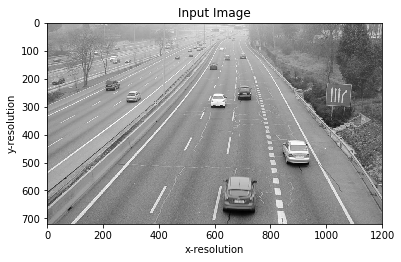

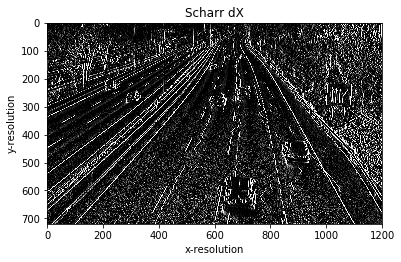

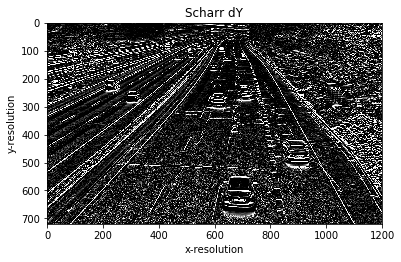

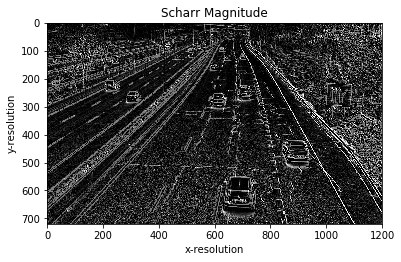

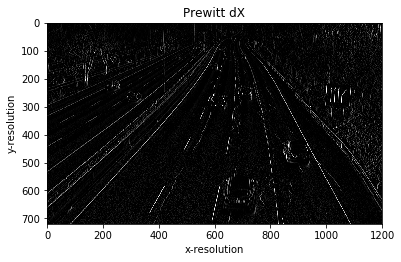

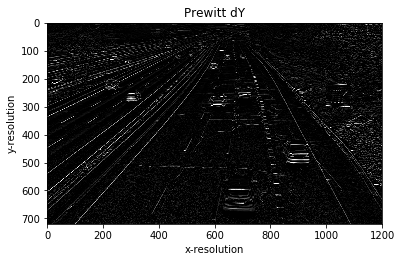

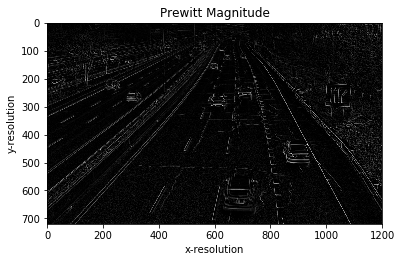

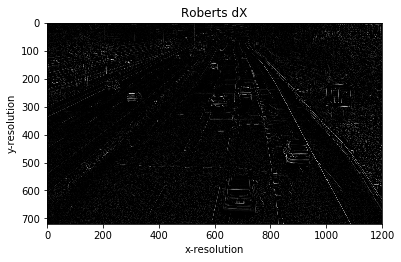

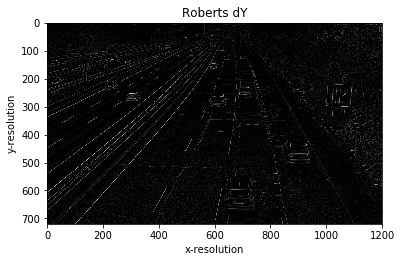

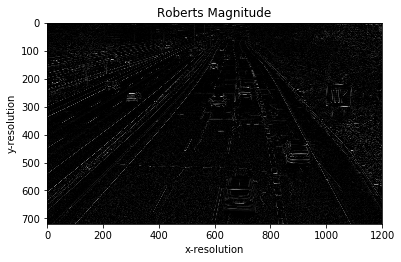

In [5]:
def compute_filter(input_img, kernel_x, kernel_y, name, idx):
    """
        Given a kernel for the x and y direction respectively, the function
        calculates the convolution and obtains the magnitude of it.
        Then it displays the results.
    """
    
    # Calculate the convolution of both kernels in the x and y direciton.
    img_dx = cv2.filter2D(input_img, -1, kernel_x)
    img_dy = cv2.filter2D(input_img, -1, kernel_y)
    
    # Take the absolute values of the convolution.
    img_dx_abs = cv2.convertScaleAbs(img_dx)
    img_dy_abs = cv2.convertScaleAbs(img_dy)
    
    # Combine results into a single image.
    img_mag = cv2.addWeighted(img_dx, 0.5, img_dy, 0.5, 0)

    # Display the derivatives and the magnitude.
    visualize_image(img_dx, 2 + 3 * idx, '%s dX' % name)
    visualize_image(img_dy, 3 + 3 * idx, '%s dY' % name)
    visualize_image(img_mag, 4 + 3 * idx, '%s Magnitude' % name)
    
# Read image as color and convert it to grayscale.
img = read_image_safe(IMAGE_IN_FILENAME, cv2.IMREAD_COLOR, cv2.COLOR_BGR2GRAY)

# Display the input image.
visualize_image(img, 1, 'Input Image')
    
# Compute the Scharr, Prewitt and Roboerts Filter.
compute_filter(img, SCHARR_KERNEL_X, SCHARR_KERNEL_Y, 'Scharr', 0)
compute_filter(img, PREWITT_KERNEL_X, PREWITT_KERNEL_Y, 'Prewitt', 1)
compute_filter(img, ROBERTS_KERNEL_X, ROBERTS_KERNEL_Y, 'Roberts', 2)

The main algorithm inside the function `compute_filter` has been found on several sites. Nonetheless, the results obtained do not appear to be valid. Other methods require to convert the image from a type of `CV_8U` to `CV_32F` before doing the convolution. Important to note is that a `CV_32F` is a float where every pixel has a value ranging from 0 to 1.0.

Some key functions used in this section are:
- `cv2.cartToPolar(x, y[, magnitude[, angle[, angleInDegrees]]])`
    - Calculates the magnitude and angle of 2D vectors.
    - x – Array of x-coordinates; this must be a single-precision or double-precision floating-point array.
    - y – Array of y-coordinates, that must have the same size and same type as x.
    - magnitude – Output array of magnitudes of the same size and type as x.
    - angle – Output array of angles that has the same size and type as x; the angles are measured in radians (from 0 to 2*Pi) or in degrees (0 to 360 degrees).
    - angleInDegrees – A flag, indicating whether the angles are measured in radians (which is by default), or in degrees.
    - **returns** - (magnitude, angle)

Source:
- https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html


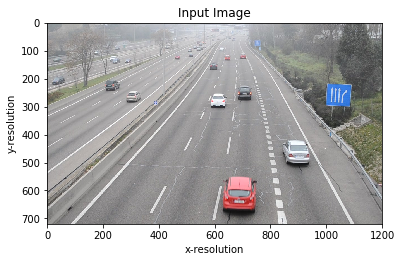

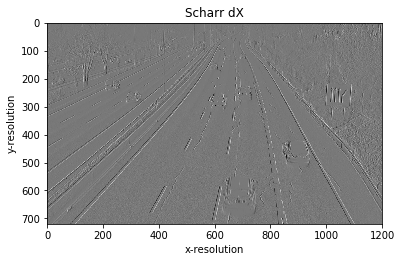

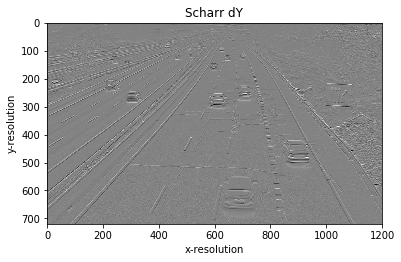

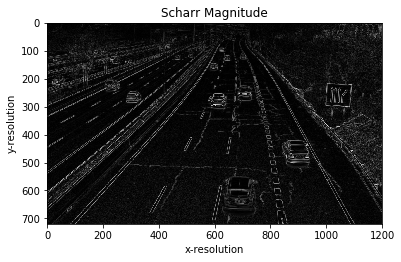

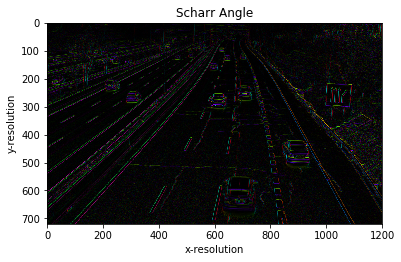

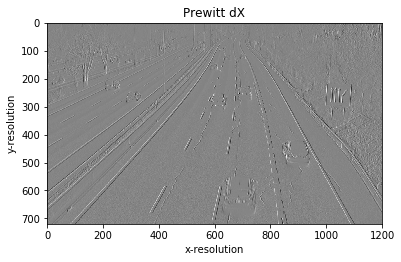

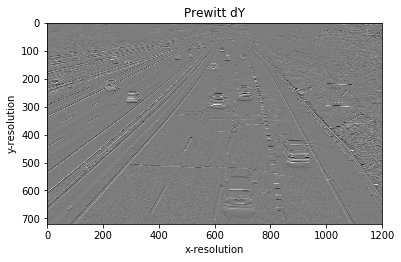

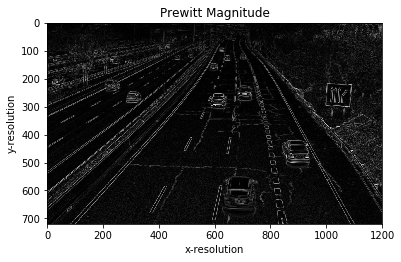

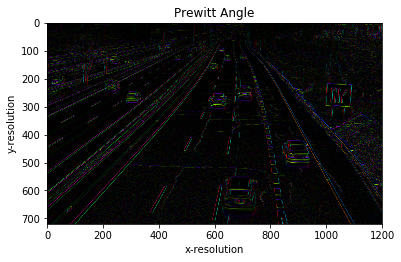

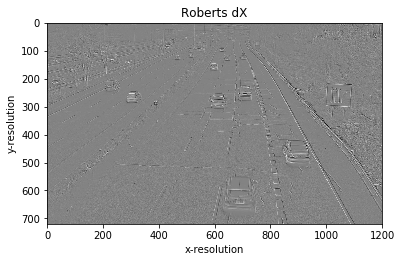

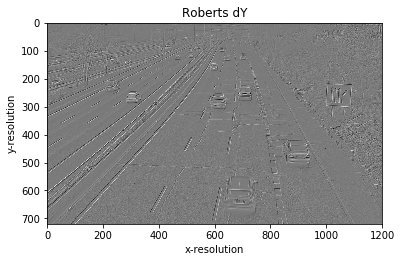

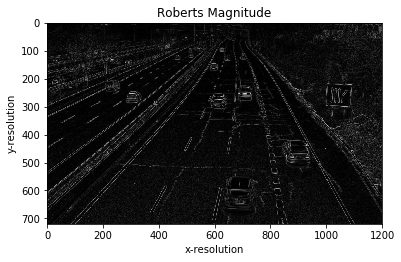

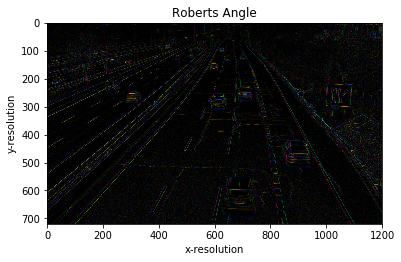

In [6]:
def compute_filter(input_img, kernel_x, kernel_y, name, idx):
    """
        Given a kernel for the x and y direction respectively, the function
        calculates the convolution and obtains the magnitude of it.
        Then it displays the results.
    """
    
    # Convert input image to gray scale.
    gray_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the convolution of both kernels in the x and y direciton.
    img_dx = cv2.filter2D(gray_img, cv2.CV_32F, kernel_x)
    img_dy = cv2.filter2D(gray_img, cv2.CV_32F, kernel_y)
    
    # Calculate the magnitude of the derivatives.
    img_mag, img_ang = cv2.cartToPolar(img_dx, img_dy)
    
    # To display the angle of the derivative, create a copy of the 
    # magnitude image that changes color depending on the angle.
    hsv = np.zeros_like(input_img).astype(np.uint8)
    
    # Hue depends on the angle. Must be converted from radians
    # to degrees.
    hsv[..., 0] = img_ang * 180 / np.pi / 2
    
    # Saturation is 100%
    hsv[..., 1] = 255
    
    # Value depends on the intensity of the magnitude. The values
    # must be normalized from 0-255.
    hsv[..., 2] = cv2.normalize(img_mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convert hsv image to rgb for displaying purposes.
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Display the derivatives and the magnitude.
    visualize_image(img_dx, 2 + 4 * idx, '%s dX' % name)
    visualize_image(img_dy, 3 + 4 * idx, '%s dY' % name)
    visualize_image(img_mag, 4 + 4 * idx, '%s Magnitude' % name)
    visualize_image(rgb, 5 + 4 * idx, '%s Angle' % name)
    
    # Save angle images.
    cv2.imwrite('%s_angle.jpg' % name, rgb)
    
# Read image as color and convert it to RGB.
img = read_image_safe(IMAGE_IN_FILENAME, cv2.IMREAD_COLOR, cv2.COLOR_BGR2RGB)

# Display the input image.
visualize_image(img, 1, 'Input Image')

# Compute the Scharr, Prewitt and Roboerts Filter.
compute_filter(img, SCHARR_KERNEL_X, SCHARR_KERNEL_Y, 'Scharr', 0)
compute_filter(img, PREWITT_KERNEL_X, PREWITT_KERNEL_Y, 'Prewitt', 1)
compute_filter(img, ROBERTS_KERNEL_X, ROBERTS_KERNEL_Y, 'Roberts', 2)

### Conclusions

After analyzing the results obtained from the two methods presented for calculating edge detection algorithms, the second algorithm is the clear winner. The results obtained show clearly the detection of lines. Furthermore, the color representation of the direction of the derivative is consistent with similar lines. For instance, all lane lines with similar direction tend to have the same hue color. 

Although the magnitude outputs of the Scharr, Prewitt, and Roberts algorithms seem similar, they are quite different in the angle output. This is confirmed when looking at the angle outputs. While some lines appear red in the Scharr output, they tend to look green in the Prewitt output, thus indicating that the direction of the derivative is quite different. Finally, from the three algorithms, the Roberts kernel produced the most faint image. The reason behind this should be that the 2x2 kernel isn’t to aggressive at calculating the derivative.
 
Important to note is that the use of `cv2.filter2D` requires the image to have a depth of `cv2.CV_32F` or `cv2.CV_64F`. Doing this yielded the best results. Moreover the use of the function `cv2.cartToPolar` reduced extensively the amount of lines needed for calculating the magnitude and normalizing the image. It was no longer needed to code this functions such as in the Sobel example.

The following images show in full size the angle ouputs for the Scharr, Prewitt, and Roberts algorithms:

###### Figure 1. Scharr Angle Output
<p align="center">
    <img src="Scharr_angle.jpg" alt="Scharr Angle" width=750>
</p>

###### Figure 2. Prewitt Angle Output
<p align="center">
    <img src="Prewitt_angle.jpg" alt="Prewitt Angle" width=750>
</p>

###### Figure 3. Roberts Angle Output
<p align="center">
    <img src="Roberts_angle.jpg" alt="Roberts Angle" width=750>
</p>

_I hereby affirm that I have done this activity with academic integrity._